#### Notebook 'Tempo'

In [1]:
# Carga de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from itertools import combinations
from collections import Counter
from pyvis.network import Network
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities


In [2]:
# Crear el DataFrame 'df_aspectos' con los aspectos y las variables asociadas
data_aspectos = {
    'aspecto': ['DROGAS_Y_CORRUPCIÓN'],
    'var_1': ['per603'],
    'var_2': ['per604'],
    'var_3': ['per605'],
    'var_4': ['per104'],
    'var_5': ['per304']
}
df_aspectos = pd.DataFrame(data_aspectos)
display(df_aspectos)
# cargar Analytical_Data
df_AD = pd.read_excel('data/Analytical_Data.xlsx')
display(df_AD.head())

,aspecto,var_1,var_2,var_3,var_4,var_5
0,DROGAS_Y_CORRUPCIÓN,per603,per604,per605,per104,per304


,Dominio,Nombre_Dominio,Variable_per,Detalle_Dominio
0,Domain_1,External Relations,per101,Foreign Special Relationships: Positive
1,Domain_1,External Relations,per102,Foreign Special Relationships: Negative
2,Domain_1,External Relations,per103,Anti-Imperialism
3,Domain_1,External Relations,per104,Military: Positive
4,Domain_1,External Relations,per105,Military: Negative


In [3]:
# Cargar datasets
df = pd.read_excel('./data/MP_Dataset_KMeans_mean.xlsx')  # Dataset principal
print("Datos cargados:")
display(df.head())


Datos cargados:


,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
0,1997,Albania,1.770988,0.00000,0.031388,3.046506,0.015910,0.032313,3.406129,1.114989,...,2.021481,0.0,0.0,0.0,0.0,0.0,0.637892,0.363756,0.0,0.0
1,2001,Albania,2.392570,0.00000,0.000000,2.757403,0.026619,0.023948,3.523162,1.452779,...,0.989546,0.0,0.0,0.0,0.0,0.0,0.897238,0.508457,0.0,0.0
2,1989,Argentina,0.000000,0.00000,4.619213,0.448618,0.828036,0.338070,2.955090,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
3,1995,Argentina,0.061642,0.02014,0.143247,0.882433,0.083005,1.107286,1.996025,1.669947,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
4,1999,Argentina,0.192543,0.00000,0.582363,0.524400,0.017829,0.613450,3.482869,2.262154,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0


#### Paso 3: Funciones en pipeline de proceso

##### Filtrar y Normalizar

In [4]:
def preprocesar_periodo(df, desde, hasta):
    """
    Preprocesa el DataFrame para el período seleccionado.
    Combina registros de países con múltiples elecciones en el período y normaliza las variables.
    
    Parámetros:
    - df: DataFrame principal con datos de programas de gobierno.
    - desde: Año inicial del período.
    - hasta: Año final del período.

    Retorna:
    - df_periodo: DataFrame preprocesado con un registro por país en el período.
    """
    # Filtrar el DataFrame para el período
    df_periodo = df[(df['agno'] >= desde) & (df['agno'] <= hasta)]

    # Identificar países con más de una elección en el período
    duplicated_countries = df_periodo['countryname'].value_counts()
    duplicated_countries = duplicated_countries[duplicated_countries > 1]

    if not duplicated_countries.empty:
        #print("\nPaíses con más de una elección en el período:")
        for country in duplicated_countries.index:
            #print(f"\n{country}:")

            # Filtrar datos del país con duplicados
            country_data = df_periodo[df_periodo['countryname'] == country]

            # Imprimir los registros originales
            #print(f"Registros originales ({len(country_data)}):")
            #display(country_data)

            # Promediar las columnas `per` y conservar el primer año
            per_columns = [col for col in df_periodo.columns if col.startswith('per')]
            averaged_row = country_data[per_columns].mean().to_dict()
            averaged_row['agno'] = country_data['agno'].min()  # Primer año del período
            averaged_row['countryname'] = country

            # Imprimir los valores promedio
            #print("\nValores promediados:")
            for key, value in averaged_row.items():
                if key in per_columns:  # Solo mostrar columnas 'per'
                    print(f"{key}: {value:.4f}")

            # Eliminar los registros originales del dataframe filtrado
            df_periodo = df_periodo[df_periodo['countryname'] != country]

            # Agregar el registro promediado al dataframe
            df_periodo = pd.concat([df_periodo, pd.DataFrame([averaged_row])], ignore_index=True)

    else:
        print("\nNo hay países con más de una elección en el período.")

    # Verificar los resultados finales
    #print("\nDataframe ajustado (un registro por país en el período):")
    #display(df_periodo)

    return df_periodo


In [5]:
def filtrar_y_normalizar(df_periodo, variables):
    """
    Filtra y normaliza las columnas 'per' en un DataFrame para un período específico.
    Elimina registros con valores NaN o donde todas las columnas 'per' seleccionadas son 0.

    Parámetros:
    - df_periodo: DataFrame ya preprocesado para un período (salida de `preprocesar_periodo`).
    - variables: Lista de columnas 'per' relevantes para el aspecto en análisis.

    Retorna:
    - df_filtered: DataFrame filtrado y normalizado.
    """
    # Filtrar el DataFrame para las columnas seleccionadas
    df_filtered = df_periodo[['countryname', 'agno'] + list(variables)].copy()

    # Identificar registros con valores NaN
    registros_nan = df_filtered[df_filtered[variables].isna().any(axis=1)]
    if not registros_nan.empty:
        print("\nRegistros eliminados por contener valores NaN:")
        #display(registros_nan)

    # Eliminar registros con valores NaN
    df_filtered.dropna(inplace=True)

    # Identificar registros con todos los valores en cero
    registros_cero = df_filtered[df_filtered[variables].sum(axis=1) == 0]
    if not registros_cero.empty:
        print("\nRegistros eliminados por tener todas las variables seleccionadas en cero:")
        #display(registros_cero)

    # Eliminar registros con todos los valores en cero
    df_filtered = df_filtered[df_filtered[variables].sum(axis=1) > 0]

    # Normalizar las columnas 'per'
    columns_per = variables
    df_filtered['per_sum'] = df_filtered[columns_per].sum(axis=1)
    rows_to_normalize = df_filtered['per_sum'] != 1.0
    df_filtered.loc[rows_to_normalize, columns_per] = df_filtered.loc[rows_to_normalize, columns_per].div(
        df_filtered.loc[rows_to_normalize, 'per_sum'], axis=0
    )
    df_filtered.drop(columns=['per_sum'], inplace=True)

    # Verificar que las variables 'per' sumen 1
    assert df_filtered[columns_per].sum(axis=1).round(6).eq(1).all(), "Error: las variables 'per' no suman 1."

    return df_filtered


##### PCA y K-MEANS

In [6]:
def ejecutar_y_visualizar_pca_kmeans(df_filtered, variables, aspecto_filtro, desde, hasta):
    """
    Ejecuta PCA y K-MEANS, y visualiza los resultados en 2D y 3D con títulos personalizados.
    
    Parámetros:
    - df_filtered: DataFrame filtrado y normalizado.
    - variables: Lista de variables 'per' a incluir en el análisis.
    - aspecto_filtro: Aspecto analizado (str).
    - desde: Año inicial del período.
    - hasta: Año final del período.
    
    Retorna:
    - df_pca: DataFrame con las componentes principales y los clústeres.
    - pca: Objeto PCA ajustado.
    - kmeans: Objeto K-MEANS ajustado.
    """
    # Paso 1: Ejecutar PCA
    numeric_data = df_filtered[variables]
    pca = PCA(n_components=min(len(variables), 3))  # Usar hasta 3 componentes principales
    pca_components = pca.fit_transform(numeric_data)
    
    # Crear DataFrame con las componentes principales
    df_pca = pd.DataFrame(
        pca_components, 
        columns=[f'PC{i+1}' for i in range(pca.n_components_)],
        index=df_filtered.index
    )
    df_pca = pd.concat([df_filtered[['countryname', 'agno']], df_pca], axis=1)
    
    # Paso 2: Aplicar K-MEANS
    optimal_k = 3  # Por defecto usamos 3 clústeres (puedes ajustar o calcular dinámicamente)
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    df_pca['cluster'] = kmeans.fit_predict(df_pca[[f'PC{i+1}' for i in range(pca.n_components_)]])
    
    # Paso 3: Visualizar clústeres en 2D
    # plt.figure(figsize=(12, 6))
    # for cluster in range(optimal_k):
    #     cluster_data = df_pca[df_pca['cluster'] == cluster]
    #     plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'Cluster {cluster}', alpha=0.7)
    # plt.title(f"Clústeres en 2D (PCA)\nAspecto: {aspecto_filtro} | Período: {desde}-{hasta}")
    # plt.xlabel('PC1')
    # plt.ylabel('PC2')
    # plt.legend()
    # plt.grid(alpha=0.3)
    # plt.tight_layout()
    # plt.show()
    
    return df_pca, pca, kmeans


##### Matriz de coincidencias

In [7]:
def construir_matriz_coincidencias(resultados_temporales):
    coincidencias = Counter()
    for clusters in resultados_temporales.values():
        for cluster in clusters.values():
            for pair in combinations(sorted(cluster), 2):
                coincidencias[pair] += 1

    # Convertir a matriz
    paises = sorted(set([p for pair in coincidencias.keys() for p in pair]))
    coincidence_matrix = pd.DataFrame(0, index=paises, columns=paises)

    for (p1, p2), count in coincidencias.items():
        coincidence_matrix.loc[p1, p2] = count
        coincidence_matrix.loc[p2, p1] = count

    return coincidence_matrix


#### Grafo de Trayectorias temporales

#### Gráfico de coincidencias (con un cierto mínimo)

In [8]:
# LOUVAIN
from pyvis.network import Network
import networkx as nx
from community import community_louvain  # Librería para Louvain

def grafo_coincidencias_filtrado(coincidence_matrix, min_coincidencias=10):
    """
    Crea un grafo interactivo mejorado a partir de la matriz de coincidencias,
    filtrando conexiones con menos de `min_coincidencias` coincidencias.
    
    Parámetros:
    - coincidence_matrix: Matriz de coincidencias entre países.
    - min_coincidencias: Número mínimo de coincidencias para mostrar una conexión.
    """
    # Crear el grafo de NetworkX
    G = nx.Graph()
    for i, row in coincidence_matrix.iterrows():
        for j, value in row.items():
            if value >= min_coincidencias:  # Filtrar por número mínimo de coincidencias
                G.add_edge(i, j, weight=value)  # Añadir peso correctamente

    # Detectar comunidades usando el algoritmo Louvain
    partition = community_louvain.best_partition(G)
    communities = {}
    for node, community in partition.items():
        communities.setdefault(community, []).append(node)

    # Crear un grafo interactivo con PyVis
    net = Network(notebook=True, height="750px", width="100%", cdn_resources="remote")
    net.from_nx(G)

    # Configurar físicas para deshabilitarlas
    net.set_options("""
    var options = {
      "physics": {
        "enabled": false
      }
    }
    """)

    # Ajustar nodos y aristas
    for node in net.nodes:
        # Color del nodo según la comunidad detectada
        community = partition[node["id"]]
        node["color"] = f"hsl({community * 360 / len(communities)}, 70%, 70%)"
        
        # Tamaño del nodo según el grado
        node["value"] = len(list(G.neighbors(node["id"])))

    for edge in net.edges:
        # Grosor de las aristas según el peso
        from_node = edge["from"]
        to_node = edge["to"]
        if G.has_edge(from_node, to_node):
            edge["width"] = G[from_node][to_node].get("weight", 1)  # Usar 1 como valor por defecto

    # Calcular métricas de centralidad
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)

    # Mostrar las métricas en la terminal
    print("\nCentralidad de Grado (Top 5):")
    for node, centrality in sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(f"{node}: {centrality:.4f}")

    print("\nCentralidad de Betweenness (Top 5):")
    for node, centrality in sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(f"{node}: {centrality:.4f}")

    # Guardar el grafo en un archivo HTML
    output_file = "LOUVAIN_grafo_coincidencias_filtrado.html"
    net.show(output_file)
    print(f"Grafo guardado como '{output_file}'. Ábrelo para visualizar.")


In [ ]:
# # GREEDY MODULARITY COMMUNITIES
# from pyvis.network import Network
# import networkx as nx
# from networkx.algorithms.community import greedy_modularity_communities

# def grafo_coincidencias_filtrado(coincidence_matrix, min_coincidencias=10):
#     """
#     Crea un grafo interactivo mejorado a partir de la matriz de coincidencias,
#     filtrando conexiones con menos de `min_coincidencias` coincidencias.
    
#     Parámetros:
#     - coincidence_matrix: Matriz de coincidencias entre países.
#     - min_coincidencias: Número mínimo de coincidencias para mostrar una conexión.
#     """
#     # Crear el grafo de NetworkX
#     G = nx.Graph()
#     for i, row in coincidence_matrix.iterrows():
#         for j, value in row.items():
#             if value >= min_coincidencias:  # Filtrar por número mínimo de coincidencias
#                 G.add_edge(i, j, weight=value)  # Añadir peso correctamente

#     # Detectar comunidades usando modularidad
#     communities = list(greedy_modularity_communities(G))
#     community_map = {}
#     for community_index, community_nodes in enumerate(communities):
#         for node in community_nodes:
#             community_map[node] = community_index

#     # Crear un grafo interactivo con PyVis
#     net = Network(notebook=True, height="750px", width="100%", cdn_resources="remote")
#     net.from_nx(G)

#     # Configurar físicas para deshabilitarlas
#     net.set_options("""
#     var options = {
#       "physics": {
#         "enabled": false
#       }
#     }
#     """)

#     # Ajustar nodos y aristas
#     for node in net.nodes:
#         # Color del nodo según la comunidad
#         community = community_map[node["id"]]
#         node["color"] = f"hsl({community * 360 / len(communities)}, 70%, 70%)"
        
#         # Tamaño del nodo según el grado
#         node["value"] = len(list(G.neighbors(node["id"])))

#     for edge in net.edges:
#         # Grosor de las aristas según el peso
#         from_node = edge["from"]
#         to_node = edge["to"]
#         if G.has_edge(from_node, to_node):
#             edge["width"] = G[from_node][to_node].get("weight", 1)  # Usar 1 como valor por defecto

#     # Guardar el grafo en un archivo HTML
#     output_file = "GREEDY_grafo_coincidencias_filtrado.html"
#     net.show(output_file)
#     print(f"Grafo guardado como '{output_file}'. Ábrelo para visualizar.")
    
#     # Agregar la leyenda directamente al archivo HTML
#     legend_html = f"""
#     <div style="position: absolute; top: 10px; right: 10px; background-color: white; border: 1px solid black; padding: 10px; z-index: 1000;">
#         <strong>GRAFO DE COINCIDENCIAS</strong>
#         <strong>Leyenda:</strong>
#         <ul style="list-style-type: none; padding-left: 0;">
#             <li><strong>Nodos:</strong> Países</li>
#             <li><strong>Tamaño:</strong> Grado del nodo (cantidad de conexiones)</li>
#             <li><strong>Color:</strong> Comunidad detectada</li>
#             <li><strong>Aristas:</strong> Coincidencias entre países</li>
#             <li><strong>Grosor:</strong> Peso de la conexión (coincidencias >= {min_coincidencias})</li>
#         </ul>
#     </div>
#     """
#     with open(output_file, "r", encoding="utf-8") as file:
#         html_content = file.read()
    
#     # Insertar la leyenda antes del cierre del body
#     html_content = html_content.replace("</body>", legend_html + "\n</body>")
    
#     with open(output_file, "w", encoding="utf-8") as file:
#         file.write(html_content)

#     print("Leyenda añadida al archivo HTML.")


#### Heatmap de coincidencias (con un cierto mínimo)

In [9]:
def heatmap_coincidencias_filtrado(coincidence_matrix, min_coincidencias=10, cmap="coolwarm"):
    """
    Genera un heatmap mostrando solo los países que tienen coincidencias >= min_coincidencias,
    con las celdas que cumplen mostrando el número real de coincidencias y las que no cumplen en blanco.
    
    Parámetros:
    - coincidence_matrix: Matriz de coincidencias entre países.
    - min_coincidencias: Número mínimo de coincidencias para considerar un enlace.
    - cmap: Paleta de colores para el heatmap.
    """
    # Crear una copia de la matriz para no modificar el original
    filtered_matrix = coincidence_matrix.copy()
    
    # Filtrar países que cumplen el umbral en filas o columnas
    relevant_countries = (filtered_matrix >= min_coincidencias).sum(axis=1) > 0
    filtered_matrix = filtered_matrix.loc[relevant_countries, relevant_countries]
    
    # Crear una máscara para ocultar valores por debajo del umbral
    mask = filtered_matrix < min_coincidencias
    
    # Verificar si quedan datos para graficar
    if filtered_matrix.empty:
        print(f"No hay países con coincidencias >= {min_coincidencias}.")
        return
    
    # Crear el heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        filtered_matrix,
        annot=filtered_matrix.where(~mask).round(0),  # Mostrar valores enteros redondeados
        fmt="g",  # Usar formato general (float/int)
        cmap=cmap,
        linewidths=0.5,  # Añadir líneas de la grilla
        linecolor="gray",
        cbar_kws={"label": "Número de Coincidencias"},
        mask=mask  # Aplicar la máscara
    )
    plt.title(f"Heatmap de Coincidencias Filtrado (≥ {min_coincidencias})", fontsize=14)
    plt.xlabel("País")
    plt.ylabel("País")
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()


#### Ejecución para un período

In [ ]:
# Definir el período específico
desde = 2019
hasta = 2022

# Definir las variables asociadas al aspecto de análisis
aspecto_filtro = 'DROGAS_Y_CORRUPCIÓN'
variables = df_aspectos[df_aspectos['aspecto'] == aspecto_filtro][['var_1', 'var_2', 'var_3', 'var_4', 'var_5']].dropna().values.flatten()

# Preprocesar y normalizar los datos del período seleccionado
df_periodo = preprocesar_periodo(df, desde, hasta)
df_filtered = filtrar_y_normalizar(df_periodo, variables)

# Verificar el resultado del DataFrame filtrado
print("\nDataFrame filtrado y normalizado:")
print(df_filtered.info())
display(df_filtered.head())

# Ejecutar y visualizar PCA y K-MEANS
df_pca, pca, kmeans = ejecutar_y_visualizar_pca_kmeans(df_filtered, variables, aspecto_filtro, desde, hasta)



#### Ejecución para Múltiples Períodos


Procesando período: 1949-1951
per101: 2.1474
per102: 0.0000
per103: 0.0000
per104: 4.9943
per105: 0.6320
per106: 0.8173
per107: 1.6590
per108: 0.0000
per109: 0.0614
per110: 0.0000
per201: 1.7767
per202: 0.9856
per203: 2.0346
per204: 0.0000
per301: 0.6445
per302: 0.1459
per303: 3.9862
per304: 0.0000
per305: 5.0049
per401: 4.0828
per402: 1.2052
per403: 1.9520
per404: 3.2042
per405: 0.0000
per406: 0.3774
per407: 0.0829
per408: 7.3901
per409: 0.0000
per410: 2.9427
per411: 2.3328
per412: 0.0000
per413: 0.1911
per414: 6.9560
per415: 0.0000
per416: 0.0000
per501: 0.0000
per502: 1.9677
per503: 0.0717
per504: 6.2054
per505: 0.4563
per506: 0.4265
per507: 0.0000
per601: 0.0000
per602: 0.0000
per603: 1.5246
per604: 0.0000
per605: 0.1459
per606: 6.4896
per607: 0.0000
per608: 0.0000
per701: 10.0045
per702: 0.9515
per703: 9.5408
per704: 0.5288
per705: 0.0000
per706: 3.8357
per1011: 0.0000
per1012: 0.0000
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.0000
per1021: 0.0000
per1022: 0.0000


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



Procesando período: 1958-1960
per101: 0.0000
per102: 0.1926
per103: 0.0000
per104: 0.5380
per105: 0.5684
per106: 1.9586
per107: 1.0020
per108: 0.3747
per109: 0.1196
per110: 0.0000
per201: 1.3564
per202: 0.4778
per203: 0.0817
per204: 0.0409
per301: 2.4830
per302: 0.0000
per303: 0.8103
per304: 0.0000
per305: 0.0000
per401: 2.8665
per402: 5.3536
per403: 1.3461
per404: 0.1189
per405: 0.0000
per406: 0.5214
per407: 0.2334
per408: 1.2524
per409: 0.4382
per410: 1.0118
per411: 1.7636
per412: 0.3731
per413: 0.0269
per414: 9.4882
per415: 0.0000
per416: 0.0000
per501: 0.0320
per502: 0.5464
per503: 2.2538
per504: 21.3379
per505: 1.9741
per506: 6.2660
per507: 0.1464
per601: 0.0000
per602: 0.0000
per603: 1.7193
per604: 0.0000
per605: 0.4652
per606: 0.2312
per607: 1.0414
per608: 0.0000
per701: 0.0693
per702: 0.0000
per703: 3.5806
per704: 0.0000
per705: 0.0000
per706: 2.8565
per1011: 0.0000
per1012: 0.0000
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.0000
per1021: 0.0000
per1022: 0.0000


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/

per101: 1.8445
per102: 0.0000
per103: 1.5051
per104: 1.6528
per105: 1.9693
per106: 3.9145
per107: 2.4168
per108: 1.5861
per109: 3.2186
per110: 0.5033
per201: 3.4277
per202: 4.5748
per203: 4.0696
per204: 1.3839
per301: 2.1684
per302: 0.1546
per303: 0.5027
per304: 1.4515
per305: 3.3942
per401: 0.7133
per402: 2.3040
per403: 3.2691
per404: 2.2784
per405: 0.0000
per406: 0.2621
per407: 0.4125
per408: 3.2637
per409: 0.0000
per410: 3.2084
per411: 2.6056
per412: 1.2316
per413: 1.4142
per414: 0.3864
per415: 0.0000
per416: 0.0000
per501: 0.3365
per502: 1.4177
per503: 7.0985
per504: 3.9412
per505: 1.1139
per506: 3.4996
per507: 0.0000
per601: 3.4949
per602: 1.9875
per603: 1.2316
per604: 0.6460
per605: 0.5895
per606: 0.5945
per607: 0.4114
per608: 0.4371
per701: 3.0592
per702: 0.0000
per703: 3.1962
per704: 1.4663
per705: 0.8464
per706: 3.6586
per1011: 0.0000
per1012: 0.0000
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.0000
per1021: 0.0000
per1022: 0.0000
per1023: 0.0000
per1024: 0.0000


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/


Procesando período: 1979-1981
per101: 0.0840
per102: 0.0000
per103: 0.6863
per104: 1.7031
per105: 0.0000
per106: 0.3679
per107: 1.4103
per108: 0.0000
per109: 0.0000
per110: 0.0000
per201: 1.1246
per202: 1.3890
per203: 0.0000
per204: 0.0000
per301: 1.9530
per302: 1.3637
per303: 3.0762
per304: 0.0382
per305: 0.4517
per401: 5.9932
per402: 6.3309
per403: 1.0594
per404: 1.5006
per405: 0.2073
per406: 1.0681
per407: 0.0886
per408: 11.5406
per409: 2.6489
per410: 1.8872
per411: 11.8633
per412: 1.3565
per413: 2.0355
per414: 2.7794
per415: 0.0000
per416: 0.0000
per501: 1.2252
per502: 0.3418
per503: 2.2945
per504: 7.6721
per505: 0.0382
per506: 0.0000
per507: 0.0000
per601: 0.0681
per602: 0.0000
per603: 0.1338
per604: 0.0000
per605: 0.4913
per606: 0.0667
per607: 4.5910
per608: 2.9667
per701: 0.2738
per702: 0.0000
per703: 1.2205
per704: 1.5610
per705: 1.1010
per706: 7.9263
per1011: 0.0000
per1012: 0.0000
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.0000
per1021: 0.0000
per1022: 0.0000

/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



Procesando período: 1991-1993

No hay países con más de una elección en el período.

Procesando período: 1994-1996
per101: 0.0000
per102: 0.0000
per103: 0.0000
per104: 0.7975
per105: 0.0209
per106: 0.6113
per107: 2.6289
per108: 1.5122
per109: 0.3671
per110: 0.3636
per201: 4.9681
per202: 2.2607
per203: 1.1890
per204: 0.0000
per301: 0.6372
per302: 0.0256
per303: 8.0418
per304: 4.1051
per305: 10.3292
per401: 6.2473
per402: 3.5749
per403: 0.8556
per404: 0.0640
per405: 0.0421
per406: 0.0549
per407: 0.2746
per408: 3.8976
per409: 0.0823
per410: 2.8806
per411: 4.3500
per412: 0.0144
per413: 0.0586
per414: 3.4086
per415: 0.0000
per416: 0.0250
per501: 5.1389
per502: 1.0048
per503: 6.9750
per504: 3.5271
per505: 1.2768
per506: 3.1195
per507: 0.0000
per601: 1.6126
per602: 0.1256
per603: 1.7638
per604: 0.2364
per605: 3.3267
per606: 1.9865
per607: 0.2342
per608: 0.0723
per701: 1.0026
per702: 0.0000
per703: 0.9077
per704: 0.0707
per705: 1.5341
per706: 1.1712
per1011: 0.0000
per1012: 0.0000
per1013: 0.

/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/


Procesando período: 2003-2005
per101: 1.1152
per102: 0.1418
per103: 0.2649
per104: 5.3139
per105: 0.0751
per106: 0.3354
per107: 2.1980
per108: 2.5252
per109: 0.0000
per110: 0.0000
per201: 2.2684
per202: 6.5843
per203: 1.5321
per204: 0.3745
per301: 1.8070
per302: 0.0000
per303: 4.5328
per304: 3.0439
per305: 3.5395
per401: 1.6388
per402: 1.8279
per403: 2.2367
per404: 0.1696
per405: 0.0000
per406: 0.3387
per407: 0.0855
per408: 0.6757
per409: 0.0000
per410: 2.0182
per411: 7.6245
per412: 2.2307
per413: 0.0416
per414: 2.1935
per415: 0.0000
per416: 0.1502
per501: 2.7856
per502: 5.3675
per503: 1.4917
per504: 8.0031
per505: 0.9756
per506: 4.7850
per507: 0.0000
per601: 4.7099
per602: 0.0000
per603: 0.9659
per604: 0.0000
per605: 3.0466
per606: 1.2004
per607: 0.7081
per608: 0.0000
per701: 2.2482
per702: 0.0751
per703: 3.3457
per704: 0.6721
per705: 0.0000
per706: 1.1519
per1011: 0.0000
per1012: 0.0000
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.0000
per1021: 0.0000
per1022: 0.0000
p

/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/


Procesando período: 2015-2017
per101: 0.2469
per102: 0.0492
per103: 0.0574
per104: 3.1166
per105: 0.4647
per106: 0.6247
per107: 2.5816
per108: 1.5145
per109: 0.1046
per110: 2.4327
per201: 2.6093
per202: 3.5277
per203: 0.0640
per204: 0.3812
per301: 4.0770
per302: 0.1992
per303: 1.6447
per304: 0.2069
per305: 0.8810
per401: 0.5627
per402: 2.2865
per403: 5.2391
per404: 1.3592
per405: 0.2874
per406: 0.3672
per407: 0.8576
per408: 0.4079
per409: 0.3550
per410: 1.5884
per411: 7.5769
per412: 0.8187
per413: 0.7673
per414: 1.9440
per415: 0.0000
per416: 1.2585
per501: 4.2332
per502: 1.5418
per503: 7.2965
per504: 12.7320
per505: 0.8405
per506: 4.2755
per507: 0.0061
per601: 2.9657
per602: 0.4046
per603: 0.3379
per604: 0.0598
per605: 5.7303
per606: 1.6092
per607: 0.3259
per608: 0.3048
per701: 4.0773
per702: 0.1556
per703: 1.3014
per704: 0.0649
per705: 0.4047
per706: 0.5512
per1011: 0.0000
per1012: 0.0000
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.0000
per1021: 0.0000
per1022: 0.0000


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



Centralidad de Grado (Top 5):
New Zealand: 0.4706
Denmark: 0.4118
Sweden: 0.3529
Iceland: 0.2941
Australia: 0.2353

Centralidad de Betweenness (Top 5):
New Zealand: 0.3542
Denmark: 0.2819
Sweden: 0.2304
Iceland: 0.2004
Germany: 0.1746
LOUVAIN_grafo_coincidencias_filtrado.html
Grafo guardado como 'LOUVAIN_grafo_coincidencias_filtrado.html'. Ábrelo para visualizar.


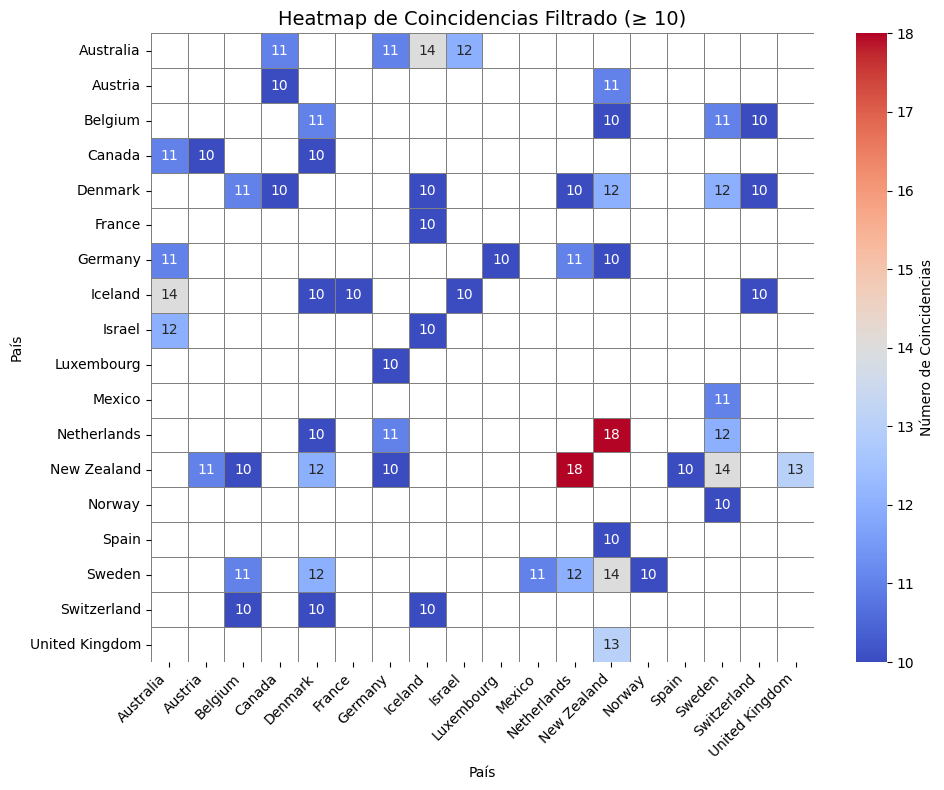

In [10]:
# Definir períodos múltiples para el análisis
periodos = [(1949, 1951),(1952, 1954),(1955, 1957),(1958, 1960),(1961, 1963),(1964, 1966), (1967, 1969), (1970, 1972), (1973, 1975), (1976, 1978), (1979, 1981), (1982, 1984), (1985, 1987), (1988, 1990), (1991, 1993), (1994, 1996), (1997, 1999), (2000, 2002), (2003, 2005), (2006, 2008), (2009, 2011), (2012, 2014), (2015, 2017), (2018, 2020), (2021, 2022)]
aspecto_filtro = 'DROGAS_Y_CORRUPCIÓN'
variables = df_aspectos[df_aspectos['aspecto'] == aspecto_filtro][['var_1', 'var_2', 'var_3', 'var_4', 'var_5']].dropna().values.flatten()

# Diccionario para almacenar resultados por período
resultados_temporales = {}

for desde, hasta in periodos:
    print(f"\nProcesando período: {desde}-{hasta}")
    
    # Preprocesar y normalizar datos
    df_periodo = preprocesar_periodo(df, desde, hasta)
    df_filtered = filtrar_y_normalizar(df_periodo, variables)
    
    # Ejecutar PCA y K-MEANS
    df_pca, pca, kmeans = ejecutar_y_visualizar_pca_kmeans(df_filtered, variables, aspecto_filtro, desde, hasta)
    
    # Almacenar los países en cada clúster
    clusters = {}
    for cluster in df_pca['cluster'].unique():
        clusters[cluster] = df_pca[df_pca['cluster'] == cluster]['countryname'].unique()
    resultados_temporales[f"{desde}-{hasta}"] = clusters

# Construir y visualizar la matriz de coincidencias
coincidence_matrix = construir_matriz_coincidencias(resultados_temporales)
#grafo_coincidencias(coincidence_matrix)

#paises_seleccionados = ["Armenia", "Finland", "United States", "Australia", "Georgia"]
#paises_seleccionados = ["Armenia", "United States"]
#graficar_trayectorias_seleccion(resultados_temporales, paises_seleccionados)
grafo_coincidencias_filtrado(coincidence_matrix, min_coincidencias=10)

# Ejecutar heatmap filtrando según un umbral
heatmap_coincidencias_filtrado(coincidence_matrix, min_coincidencias=10, cmap="coolwarm")

In [ ]:
coincidence_matrix

### <<<<<<<<<<<< NO USAR DESDE >>>>>>>>>>>>

In [ ]:
def generar_dataframe_por_periodo(periodo, resultados_temporales):
    """
    Genera un DataFrame para un período específico con columnas 'periodo', 'Cluster_1', 'Cluster_2', 'Cluster_3'.
    Cada columna de clúster contiene los países listados verticalmente.
    
    Parámetros:
    - periodo: Periodo en formato 'YYYY-YYYY' (ejemplo: '1970-1972').
    - resultados_temporales: Diccionario con los resultados de clústeres por período.
    
    Retorna:
    - DataFrame con las columnas 'periodo', 'Cluster_1', 'Cluster_2', 'Cluster_3'.
    """
    if periodo not in resultados_temporales:
        print(f"El período {periodo} no está en los resultados disponibles.")
        return pd.DataFrame()  # Devuelve un DataFrame vacío

    # Extraer los clústeres del período seleccionado
    clusters = resultados_temporales[periodo]

    # Obtener países en cada clúster y asegurarse de que los clusters tengan un formato uniforme
    cluster_data = {}
    max_paises = 0
    for cluster_id in range(1, 4):  # Asumimos hasta 3 clusters
        cluster_key = cluster_id - 1  # Ajustar al índice del diccionario
        paises = sorted(clusters.get(cluster_key, []))  # Obtener países en el clúster o lista vacía
        cluster_data[f"Cluster_{cluster_id}"] = paises
        max_paises = max(max_paises, len(paises))

    # Crear un DataFrame con las columnas del clúster
    df = pd.DataFrame({
        "periodo": [periodo] * max_paises,  # Repetir el período
        "Cluster_1": cluster_data.get("Cluster_1", []) + [None] * (max_paises - len(cluster_data.get("Cluster_1", []))),
        "Cluster_2": cluster_data.get("Cluster_2", []) + [None] * (max_paises - len(cluster_data.get("Cluster_2", []))),
        "Cluster_3": cluster_data.get("Cluster_3", []) + [None] * (max_paises - len(cluster_data.get("Cluster_3", []))),
    })

    return df

# Ejemplo de uso:
# Cambia '2019-2022' por el período que desees analizar
periodo_seleccionado = '2019-2022'
df_periodo = generar_dataframe_por_periodo(periodo_seleccionado, resultados_temporales)

# Mostrar el DataFrame
print(f"Clústeres para el período {periodo_seleccionado}:")
display(df_periodo)


In [ ]:
dfs_por_periodo = []
for periodo in resultados_temporales.keys():
    df = generar_dataframe_por_periodo(periodo, resultados_temporales)
    dfs_por_periodo.append(df)

# Combinar todos los DataFrames en uno grande si lo necesitas
df_combinado = pd.concat(dfs_por_periodo, ignore_index=True)


In [ ]:
display(df_combinado)

In [ ]:
# Define the minimum coincidences threshold
min_coincidencias = 10

# Initialize a dictionary to count the number of significant links for each country
significant_links = {}

# Iterate over the rows of the coincidence matrix
for country, row in coincidence_matrix.iterrows():
    # Count the number of connections exceeding the threshold
    count = (row >= min_coincidencias).sum()
    significant_links[country] = count

# Create a DataFrame from the significant links
significant_links_df = pd.DataFrame(
    list(significant_links.items()),
    columns=["Country", "Number of Significant Links"]
).sort_values(by="Number of Significant Links", ascending=False)

# Display the results in a user-friendly table
#import ace_tools as tools; tools.display_dataframe_to_user(name="Significant Links by Country", dataframe=significant_links_df)

# Print for reference
print(f"Countries with significant links (>= {min_coincidencias} coincidences):")
display(significant_links_df)


In [ ]:
# Define the minimum coincidences threshold
min_coincidencias = 10

# Initialize a dictionary to store the sum of significant links for each country
significant_sums = {}

# Iterate over the rows of the coincidence matrix
for country, row in coincidence_matrix.iterrows():
    # Sum the values of connections exceeding the threshold
    total_sum = row[row >= min_coincidencias].sum()
    significant_sums[country] = total_sum

# Create a DataFrame from the significant sums
significant_sums_df = pd.DataFrame(
    list(significant_sums.items()),
    columns=["Country", "Sum of Significant Links"]
).sort_values(by="Sum of Significant Links", ascending=False)

# Display the results in a user-friendly table

# Print for reference
print(f"Countries with significant link sums (>= {min_coincidencias} coincidences):")
significant_sums_df


### <<<<<<<<<<<< NO USAR HASTA >>>>>>>>>>>>

#### Análisis de la modularidad de la partición en comunidades según Greedy y según Louvain
* La modularidad es una métrica que mide la calidad de una partición en comunidades en un grafo. Una modularidad más alta indica una mejor partición, donde hay más enlaces dentro de las comunidades que los esperados por azar.
* Calcularemos la modularidad en NetworkX utilizando la función modularity() y las particiones generadas por Greedy y Louvain.

In [ ]:
# Cálculo de modularidad usando Louvain y Greedy
from pyvis.network import Network
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
from community import community_louvain

def grafo_coincidencias_filtrado_y_modularidad(coincidence_matrix, min_coincidencias=10):
    """
    Crea un grafo interactivo a partir de la matriz de coincidencias,
    calcula las modularidades y muestra las comunidades detectadas.
    
    Parámetros:
    - coincidence_matrix: Matriz de coincidencias entre países.
    - min_coincidencias: Número mínimo de coincidencias para mostrar una conexión.
    """
    # Crear el grafo de NetworkX
    G = nx.Graph()
    for i, row in coincidence_matrix.iterrows():
        for j, value in row.items():
            if value >= min_coincidencias:  # Filtrar por número mínimo de coincidencias
                G.add_edge(i, j, weight=value)

    # Calcular comunidades y modularidad
    calcular_modularidad_y_etiquetar(G)

    # Crear un grafo interactivo con PyVis
    net = Network(notebook=True, height="750px", width="100%", cdn_resources="remote")
    net.from_nx(G)

    # Configurar físicas para deshabilitarlas
    net.set_options("""
    var options = {
      "physics": {
        "enabled": false
      }
    }
    """)

    # Ajustar nodos y aristas
    for node in net.nodes:
        # Color del nodo según la comunidad Louvain
        louvain_community = G.nodes[node["id"]].get("Louvain_Community", "Unassigned")
        community_color = hash(louvain_community) % 360  # Color basado en hash
        node["color"] = f"hsl({community_color}, 70%, 70%)"
        
        # Tamaño del nodo según el grado
        node["value"] = len(list(G.neighbors(node["id"])))

    for edge in net.edges:
        # Grosor de las aristas según el peso
        from_node = edge["from"]
        to_node = edge["to"]
        if G.has_edge(from_node, to_node):
            edge["width"] = G[from_node][to_node].get("weight", 1)  # Usar 1 como valor por defecto

    # Guardar el grafo en un archivo HTML
    output_file = "grafo_coincidencias_filtrado.html"
    net.show(output_file)
    print(f"Grafo guardado como '{output_file}'. Ábrelo para visualizar.")
    
    # Agregar la leyenda directamente al archivo HTML
    legend_html = f"""
    <div style="position: absolute; top: 10px; right: 10px; background-color: white; border: 1px solid black; padding: 10px; z-index: 1000;">
        <strong>GRAFO DE COINCIDENCIAS</strong>
        <strong>Leyenda:</strong>
        <ul style="list-style-type: none; padding-left: 0;">
            <li><strong>Nodos:</strong> Países</li>
            <li><strong>Tamaño:</strong> Grado del nodo (cantidad de conexiones)</li>
            <li><strong>Color:</strong> Comunidad detectada</li>
            <li><strong>Aristas:</strong> Coincidencias entre países</li>
            <li><strong>Grosor:</strong> Peso de la conexión (coincidencias >= {min_coincidencias})</li>
        </ul>
    </div>
    """
    with open(output_file, "r", encoding="utf-8") as file:
        html_content = file.read()
    
    # Insertar la leyenda antes del cierre del body
    html_content = html_content.replace("</body>", legend_html + "\n</body>")
    
    with open(output_file, "w", encoding="utf-8") as file:
        file.write(html_content)

    print("Leyenda añadida al archivo HTML.")

def calcular_modularidad_y_etiquetar(G):
    """
    Calcula las comunidades utilizando Greedy y Louvain, 
    asigna nombres de comunidad como atributos y muestra las modularidades.
    
    Parámetros:
    - G: Grafo generado a partir de la matriz de coincidencias.
    """
    # Greedy Modularity Communities
    greedy_communities = list(greedy_modularity_communities(G))
    greedy_modularity = nx.algorithms.community.modularity(G, greedy_communities)

    # Crear un mapeo nodo -> comunidad para Greedy
    greedy_map = {}
    for i, community in enumerate(greedy_communities):
        for node in community:
            greedy_map[node] = f"Greedy_{i + 1}"  # Etiqueta: Greedy_1, Greedy_2, etc.

    # Louvain Modularity Communities
    louvain_partition = community_louvain.best_partition(G)
    louvain_modularity = community_louvain.modularity(louvain_partition, G)

    # Crear un mapeo nodo -> comunidad para Louvain
    louvain_map = {node: f"Louvain_{comm}" for node, comm in louvain_partition.items()}

    # Mostrar modularidades
    print(f"Modularidad (Greedy): {greedy_modularity:.4f}")
    print(f"Modularidad (Louvain): {louvain_modularity:.4f}")

    # Asignar nombres de comunidad a los nodos como atributos
    nx.set_node_attributes(G, greedy_map, "Greedy_Community")
    nx.set_node_attributes(G, louvain_map, "Louvain_Community")

    # Mostrar las comunidades generadas
    print("\nComunidades detectadas con Greedy:")
    for i, community in enumerate(greedy_communities, start=1):
        print(f"Greedy_{i}: {sorted(community)}")

    print("\nComunidades detectadas con Louvain:")
    louvain_communities = {}
    for node, comm in louvain_partition.items():
        louvain_communities.setdefault(comm, []).append(node)
    for i, (comm, nodes) in enumerate(sorted(louvain_communities.items()), start=1):
        print(f"Louvain_{comm}: {sorted(nodes)}")

# Ejecutar el análisis con un umbral de coincidencias
grafo_coincidencias_filtrado_y_modularidad(coincidence_matrix, min_coincidencias=10)


#### Final?

In [ ]:
from pyvis.network import Network
import networkx as nx
from networkx.algorithms.community import louvain_communities
import pandas as pd

def grafo_clusters_final(coincidence_matrix, min_coincidencias=10):
    """
    Crea el grafo final de clusters basado en la matriz de coincidencias,
    filtrando por un número mínimo de coincidencias y calculando métricas de centralidad.
    """
    # Crear el grafo de NetworkX
    G = nx.Graph()
    for i, row in coincidence_matrix.iterrows():
        for j, value in row.items():
            if value >= min_coincidencias:  # Filtrar por número mínimo de coincidencias
                G.add_edge(i, j, weight=value)  # Añadir peso correctamente

    # Detectar comunidades con Louvain
    communities = louvain_communities(G, weight='weight', seed=42)
    community_map = {}
    for community_index, community_nodes in enumerate(communities):
        for node in community_nodes:
            community_map[node] = community_index

    # Listar países en cada comunidad horizontalmente
    print("\nRED DE COINCIDENCIAS\n***** Países en cada comunidad (Louvain) *****")
    community_list = []
    for community_index, community_nodes in enumerate(communities):
        countries = ", ".join(sorted(community_nodes))
        print(f"Comunidad {community_index}: [{countries}]")
        community_list.append({"Comunidad": community_index, "Países": f"[{countries}]"})

    # Crear un DataFrame con las comunidades
    community_df = pd.DataFrame(community_list)
    #display(community_df)

    # Calcular métricas de centralidad
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G, weight='weight')

    # Crear dataframes de centralidad
    degree_df = pd.DataFrame(degree_centrality.items(), columns=["País", "Centralidad de Grado"]).sort_values(
        by="Centralidad de Grado", ascending=False
    )
    betweenness_df = pd.DataFrame(betweenness_centrality.items(), columns=["País", "Centralidad de Intermediación"]).sort_values(
        by="Centralidad de Intermediación", ascending=False
    )

    print("\n***** Centralidad de Grado *****")
    display(degree_df)

    print("\n***** Centralidad de Intermediación *****")
    display(betweenness_df)

    # Crear un grafo interactivo con PyVis
    net = Network(notebook=True, height="750px", width="100%", cdn_resources="remote")
    net.from_nx(G)

    # Configurar físicas para deshabilitarlas
    net.set_options("""
    var options = {
      "physics": {
        "enabled": false
      }
    }
    """)

    # Ajustar nodos y aristas
    for node in net.nodes:
        # Color del nodo según la comunidad
        community = community_map[node["id"]]
        node["color"] = f"hsl({community * 360 / len(communities)}, 70%, 70%)"
        
        # Tamaño del nodo según el grado de centralidad
        node["value"] = degree_centrality[node["id"]] * 100
        
        # Mostrar métricas de centralidad en el tooltip
        node["title"] = f"{node['id']}<br>Centralidad de Grado: {degree_centrality[node['id']]:.4f}<br>Centralidad de Intermediación: {betweenness_centrality[node['id']]:.4f}"

    for edge in net.edges:
        # Grosor de las aristas según el peso
        from_node = edge["from"]
        to_node = edge["to"]
        if G.has_edge(from_node, to_node):
            edge["width"] = G[from_node][to_node].get("weight", 1)

    # Guardar el grafo en un archivo HTML
    output_file = "grafo_clusters_final.html"
    net.show(output_file)
    print(f"Grafo guardado como '{output_file}'. Ábrelo para visualizar.")
    
     # Agregar la leyenda directamente al archivo HTML
    legend_html = f"""
    <div style="position: absolute; top: 10px; right: 10px; background-color: white; border: 1px solid black; padding: 10px; z-index: 1000;">
        <strong>RED DE COINCIDENCIAS</strong>
        <strong>Leyenda:</strong>
        <ul style="list-style-type: none; padding-left: 0;">
            <li><strong>Nodos:</strong> Países</li>
            <li><strong>Tamaño:</strong> Grado del nodo (cantidad de conexiones)</li>
            <li><strong>Color:</strong> Comunidad detectada</li>
            <li><strong>Aristas:</strong> Coincidencias entre países</li>
            <li><strong>Grosor:</strong> Peso de la conexión (coincidencias >= {min_coincidencias})</li>
        </ul>
    </div>
    """
    
    with open(output_file, "r", encoding="utf-8") as file:
        html_content = file.read()
        
    # Insertar la leyenda antes del cierre del body
    html_content = html_content.replace("</body>", legend_html + "\n</body>")
    
    # Agregar un título al HTML del grafo
    title_html = """
    <div style="position: absolute; top: 10px; left: 10px; background-color: white; border: 1px solid black; padding: 10px; z-index: 1000;">
        <h3>Grafo Final/ Comunidades (Louvain)</h3>
    </div>
    """
    
    # Insertar el título antes del cierre del body
    html_content = html_content.replace("</body>", title_html + "\n</body>")
    
    with open(output_file, "w", encoding="utf-8") as file:
        file.write(html_content)

    print("Título añadido al archivo HTML.")


In [12]:
from pyvis.network import Network
import networkx as nx
from networkx.algorithms.community import louvain_communities
import pandas as pd
import matplotlib.pyplot as plt

def grafo_clusters_final(coincidence_matrix, min_coincidencias=10):
    """
    Crea el grafo final de clusters basado en la matriz de coincidencias,
    filtrando por un número mínimo de coincidencias y calculando métricas de centralidad.
    """
    # Crear el grafo de NetworkX
    G = nx.Graph()
    for i, row in coincidence_matrix.iterrows():
        for j, value in row.items():
            if value >= min_coincidencias:  # Filtrar por número mínimo de coincidencias
                G.add_edge(i, j, weight=value)  # Añadir peso correctamente

    # Detectar comunidades con Louvain
    communities = louvain_communities(G, weight='weight', seed=42)
    community_map = {}
    for community_index, community_nodes in enumerate(communities):
        for node in community_nodes:
            community_map[node] = community_index

    # Listar países en cada comunidad horizontalmente
    print("\nRED DE COINCIDENCIAS\n***** Países en cada comunidad (Louvain) *****")
    community_list = []
    for community_index, community_nodes in enumerate(communities):
        countries = ", ".join(sorted(community_nodes))
        print(f"Comunidad {community_index}: [{countries}]")
        community_list.append({"Comunidad": community_index, "Países": f"[{countries}]"})

    # Crear un DataFrame con las comunidades
    community_df = pd.DataFrame(community_list)
    display(community_df)

    # Calcular métricas de centralidad
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G, weight='weight')

    # Crear dataframes de centralidad
    degree_df = pd.DataFrame(degree_centrality.items(), columns=["País", "Centralidad de Grado"]).sort_values(
        by="Centralidad de Grado", ascending=False
    )
    betweenness_df = pd.DataFrame(betweenness_centrality.items(), columns=["País", "Centralidad de Intermediación"]).sort_values(
        by="Centralidad de Intermediación", ascending=False
    )

    print("\n***** Centralidad de Grado *****")
    display(degree_df)

    print("\n***** Centralidad de Intermediación *****")
    display(betweenness_df)

    # Crear un grafo interactivo con PyVis
    net = Network(notebook=True, height="750px", width="100%", cdn_resources="remote")
    net.from_nx(G)

    # Configurar físicas para deshabilitarlas
    net.set_options("""
    var options = {
      "physics": {
        "enabled": false
      }
    }
    """)

    # Ajustar nodos y aristas
    for node in net.nodes:
        # Color del nodo según la comunidad
        community = community_map[node["id"]]
        node["color"] = f"hsl({community * 360 / len(communities)}, 70%, 70%)"
        
        # Tamaño del nodo según el grado de centralidad
        node["value"] = degree_centrality[node["id"]] * 100
        
        # Mostrar métricas de centralidad en el tooltip
        node["title"] = f"{node['id']}<br>Centralidad de Grado: {degree_centrality[node['id']]:.4f}<br>Centralidad de Intermediación: {betweenness_centrality[node['id']]:.4f}"

    for edge in net.edges:
        # Grosor de las aristas según el peso
        from_node = edge["from"]
        to_node = edge["to"]
        if G.has_edge(from_node, to_node):
            edge["width"] = G[from_node][to_node].get("weight", 1)

    # Guardar el grafo interactivo en un archivo HTML
    output_file = "grafo_clusters_final.html"
    net.show(output_file)
    print(f"Grafo guardado como '{output_file}'. Ábrelo para visualizar.")
    
    # Graficar el grafo estático
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G, seed=42)  # Posiciones de los nodos
    nx.draw_networkx_nodes(G, pos, node_size=[v * 1000 for v in degree_centrality.values()],
                           cmap=plt.cm.tab20, node_color=[community_map[n] for n in G.nodes()])
    nx.draw_networkx_edges(G, pos, width=[d['weight'] / 10 for (u, v, d) in G.edges(data=True)], alpha=0.5)
    nx.draw_networkx_labels(G, pos, font_size=8, font_color="black")

    plt.title("Grafo Final/ Comunidades (Louvain)")
    plt.axis("off")
    plt.show()



RED DE COINCIDENCIAS
***** Países en cada comunidad (Louvain) *****
Comunidad 0: [Australia, Austria, Canada, France, Iceland, Israel]
Comunidad 1: [Germany, Luxembourg, Netherlands, New Zealand, Spain, United Kingdom]
Comunidad 2: [Belgium, Denmark, Mexico, Norway, Sweden, Switzerland]


,Comunidad,Países
0,0,"[Australia, Austria, Canada, France, Iceland, ..."
1,1,"[Germany, Luxembourg, Netherlands, New Zealand..."
2,2,"[Belgium, Denmark, Mexico, Norway, Sweden, Swi..."



***** Centralidad de Grado *****


,País,Centralidad de Grado
6,New Zealand,0.470588
8,Denmark,0.411765
9,Sweden,0.352941
3,Iceland,0.294118
11,Netherlands,0.235294
7,Belgium,0.235294
0,Australia,0.235294
2,Germany,0.235294
1,Canada,0.176471
10,Switzerland,0.176471



***** Centralidad de Intermediación *****


,País,Centralidad de Intermediación
6,New Zealand,0.316176
8,Denmark,0.272059
9,Sweden,0.227941
3,Iceland,0.198529
2,Germany,0.154412
1,Canada,0.073529
0,Australia,0.073529
7,Belgium,0.058824
11,Netherlands,0.058824
5,Austria,0.022059


grafo_clusters_final.html
Grafo guardado como 'grafo_clusters_final.html'. Ábrelo para visualizar.


KeyError: 'weight'

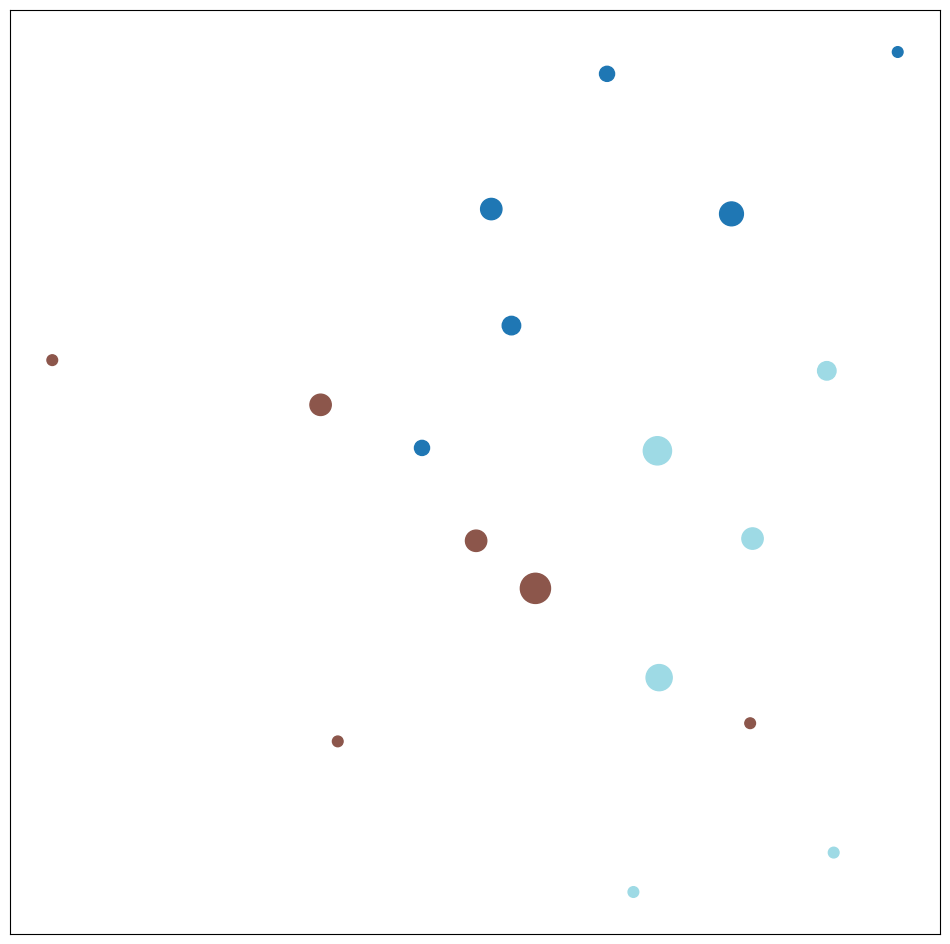

In [13]:
# Llamar a la función con un umbral de coincidencias
grafo_clusters_final(coincidence_matrix, min_coincidencias=10)



### **Análisis por Comunidad**

#### **Comunidad 0**: [Australia, Germany, Iceland, Israel]
**Concepto general**:  
**"Foco en la estabilidad interna y seguridad institucional."**  
Los países de esta comunidad comparten características como una estructura estatal bien establecida, sistemas legales sólidos y altos niveles de desarrollo humano. En términos de corrupción, suelen ocupar buenos lugares en los rankings de transparencia internacional, aunque enfrentan desafíos en ámbitos específicos.

**Enfoques según las variables 'per'**:
- **'Law and Order' (per605)**: Probablemente sobresale en esta comunidad, reflejando un compromiso con la aplicación efectiva de la ley.
- **'Political Corruption' (per304)**: Los programas presidenciales de estos países tienden a tratar la corrupción como un problema menos crítico, dada su relativa estabilidad.
- **'Military-Positive' (per104)**: El enfoque en lo militar podría estar relacionado con la seguridad estratégica en Israel y el apoyo institucional en Australia y Alemania.
- **'Traditional Morality-Positive' (per603)**: Este aspecto puede aparecer más diluido, con debates sobre modernidad versus tradición en políticas sociales.

---

#### **Comunidad 1**: [Belgium, Canada, Denmark, Switzerland]
**Concepto general**:  
**"Sistemas altamente integrados con fuerte énfasis en valores democráticos."**  
Estos países tienen una reputación de integridad gubernamental, son líderes en derechos humanos y están entre los primeros en los índices de percepción de transparencia.

**Enfoques según las variables 'per'**:
- **'Law and Order' (per605)**: Puede ser menos prominente en esta comunidad, dado que el enfoque está más en prevención y educación que en la imposición de la ley.
- **'Political Corruption' (per304)**: Aunque la corrupción es baja, estos países suelen priorizar mecanismos de transparencia y rendición de cuentas.
- **'Military-Positive' (per104)**: Tiende a tener un peso menor, reflejando sociedades más inclinadas hacia diplomacia y neutralidad (como Suiza y Dinamarca).
- **'Traditional Morality-Positive' (per603)**: Los programas presidenciales podrían abordar valores tradicionales, pero con un énfasis en derechos progresistas.

---

#### **Comunidad 2**: [Austria, Netherlands, New Zealand, Spain, United Kingdom]
**Concepto general**:  
**"Equilibrio entre tradición y modernización política."**  
Esta comunidad agrupa países con sistemas democráticos robustos que han integrado reformas modernas manteniendo elementos tradicionales.

**Enfoques según las variables 'per'**:
- **'Law and Order' (per605)**: Tiende a enfocarse en la seguridad ciudadana como un pilar clave en sus programas.
- **'Political Corruption' (per304)**: Los esfuerzos anticorrupción probablemente sean más visibles en los países mediterráneos (España), con un enfoque en combatir la corrupción histórica.
- **'Military-Positive' (per104)**: Moderado, especialmente en el Reino Unido, donde el rol militar es más prominente históricamente.
- **'Traditional Morality-Positive' (per603)**: Podría reflejar debates sociales en torno a valores familiares y religiosos, particularmente en España y Nueva Zelanda.

---

#### **Comunidad 3**: [Mexico, Norway, Sweden]
**Concepto general**:  
**"Contraste entre retos institucionales y sistemas sociales avanzados."**  
Esta comunidad une países con marcadas diferencias en niveles de desarrollo y corrupción, pero con un enfoque en políticas sociales avanzadas.

**Enfoques según las variables 'per'**:
- **'Law and Order' (per605)**: En México, el enfoque en el orden público es una prioridad crítica, mientras que en Noruega y Suecia podría relacionarse más con la percepción de seguridad en sociedades igualitarias.
- **'Political Corruption' (per304)**: México probablemente destaque en esta variable, enfrentando mayores desafíos que Noruega y Suecia, donde la corrupción es históricamente baja.
- **'Military-Positive' (per104)**: Es menos relevante en esta comunidad, reflejando la desmilitarización en Noruega y Suecia y el rol limitado del ejército en México.
- **'Traditional Morality-Positive' (per603)**: En Noruega y Suecia, esta variable podría relacionarse con valores igualitarios y avances sociales, mientras que en México podría reflejar la influencia de valores tradicionales en su política.

---

### **Conclusión General**
Estas comunidades reflejan patrones consistentes en cómo los países han abordado "Drogas y Corrupción" en sus programas presidenciales desde 1949 hasta 2022. Los resultados muestran una mezcla interesante de factores geopolíticos, sociales y económicos, lo que subraya la importancia de estudiar las variables 'per' como indicadores clave. Este análisis podría complementarse con comparaciones temporales o análisis específicos por región para profundizar aún más en las dinámicas de cada comunidad.